In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dataprep.eda import plot
from sklearn import preprocessing
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Activation
from sklearn.metrics import log_loss, confusion_matrix, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier, MLPRegressor
from collections import Counter
from utils import *

NumExpr defaulting to 4 threads.


Using TensorFlow backend.


In [120]:

table = pd.read_csv('16features.csv')

admission = pd.read_csv("mimic/ADMISSIONS.csv")
patient = pd.read_csv('mimic/PATIENTS.csv')
diagnoses = pd.read_csv('mimic/DIAGNOSES_ICD.csv')
admission['LOS'] = (pd.to_datetime(admission['DISCHTIME']) - pd.to_datetime(admission['ADMITTIME'])).dt.total_seconds()/86400
admission = admission[admission['LOS']>0]
admission = admission.merge(patient, on='SUBJECT_ID')
admission['age'] = calculate_age(admission, 'ADMITTIME', 'DOB')
admission = admission[admission['age']>=15]
admission['GENDER'] = admission['GENDER'].apply(lambda x: 1 if x=='M' else 0)
diagnoses['disease'] = diagnoses['ICD9_CODE'].apply(lambda x: D_Category[assign_category(x)])
diagnoses = diagnoses[['HADM_ID', 'disease']]
diag_oh = pd.get_dummies(diagnoses, columns=['disease'])
diag_oh = diag_oh.groupby('HADM_ID').sum()


admission = admission[['HADM_ID', 'ADMISSION_TYPE', 'GENDER', 'age', 'LOS']]
admission = admission.merge(diag_oh, on='HADM_ID')
admission

,HADM_ID,ADMISSION_TYPE,GENDER,age,LOS,disease_certain conditions originating in the perinatal period,"disease_complications of pregnancy, childbirth, and the puerperium",disease_congenital anomalies,disease_diseases of the blood and blood-forming organs,disease_diseases of the circulatory system,...,disease_diseases of the nervous system and sense organs,disease_diseases of the respiratory system,disease_diseases of the skin and subcutaneous tissue,"disease_endocrine, nutritional and metabolic diseases, and immunity disorders",disease_external causes of injury and supplemental classification,disease_infectious and parasitic diseases,disease_injury and poisoning,disease_mental disorders,disease_neoplasms,"disease_symptoms, signs, and ill-defined conditions"
0,165315,EMERGENCY,0,65,1.144444,0,0,0,0,1,...,1,0,0,0,2,0,2,1,0,0
1,152223,ELECTIVE,1,71,5.496528,0,0,0,0,4,...,1,0,0,1,1,0,0,0,0,0
2,124321,EMERGENCY,1,75,6.768056,0,0,0,0,2,...,1,0,0,2,3,0,0,0,1,1
3,161859,EMERGENCY,1,39,2.856944,0,0,0,0,2,...,0,0,0,1,0,0,0,0,0,0
4,129635,EMERGENCY,1,59,3.534028,0,0,0,0,3,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50772,190603,ELECTIVE,1,78,4.145833,0,0,0,0,1,...,1,0,0,0,3,0,0,0,0,0
50773,105447,EMERGENCY,1,88,0.662500,0,0,0,0,1,...,3,1,0,1,1,0,1,0,0,0
50774,191113,EMERGENCY,0,20,2.742361,0,0,0,1,0,...,0,0,0,0,1,0,5,0,0,0
50775,101071,EMERGENCY,0,84,0.548611,0,0,0,0,3,...,0,0,0,0,1,0,0,0,0,0


# LOS Prediction

In [121]:
data = table.merge(admission, on='HADM_ID')

data = pd.get_dummies(data, columns=['ADMISSION_TYPE'])
# # data = data.drop(['Unnamed: 0', 'HADM_ID', 'index'], axis=1)
data = data.drop(['HADM_ID', 'Unnamed: 0'], axis=1)
data['y1'] = data['LOS'].apply(lambda x: 0 if x<3 else 1)
data['y2'] = data['LOS'].apply(lambda x: 0 if x<7 else 1)
label_0 = data[data['y1']==0]
label_1 = data[data['y1']==1]
base_num = min(len(label_0), len(label_1))
label_1 = label_1.sample(n=base_num, random_state=2)
data1 = pd.concat([label_0, label_1])
y1 = data1['y1']
X1 = data1.drop(['LOS', 'y1', 'y2'], axis=1)


label_0 = data[data['y2']==0]
label_1 = data[data['y2']==1]
base_num = min(len(label_0), len(label_1))
label_0 = label_0.sample(n=base_num, random_state=1)
data2 = pd.concat([label_0, label_1])
y2 = data2['y2']
X2 = data2.drop(['LOS', 'y1', 'y2'], axis=1)

feature_names = X1.columns.values.tolist()
print(Counter(y1))
print(Counter(y2))

Counter({0: 8370, 1: 8370})
Counter({0: 24787, 1: 24787})


In [4]:
# def assign_label(x):
#     if x<3:
#         return 0
#     elif x<7:
#         return 1
#     else:
#         return 2



In [122]:
sc = preprocessing.StandardScaler()
mm = preprocessing.MinMaxScaler()
# X = sc.fit_transform(X)
X1 = mm.fit_transform(X1)
X2 = mm.fit_transform(X2)
# kb = preprocessing.KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='quantile')
# y1 = kb.fit_transform(y1.to_numpy().reshape(-1, 1))
# y1 = y1.flatten()

X2

array([[0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [1.        , 1.        , 1.        , ..., 0.        , 1.        ,
        0.        ],
       [1.        , 1.        , 1.        , ..., 0.        , 1.        ,
        0.        ],
       ...,
       [1.        , 1.        , 1.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 1.        , 0.66666667, ..., 1.        , 0.        ,
        0.        ],
       [0.5       , 0.4       , 0.33333333, ..., 0.        , 1.        ,
        0.        ]])

In [107]:
# print(kb.bin_edges_)
print(Counter(y1))
print(Counter(y2))

Counter({0: 8370, 1: 8370})
Counter({0: 25990, 1: 24722})


In [271]:
# # Resampling
# from imblearn.over_sampling import SMOTE

# # setting up testing and training sets
# X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.2, random_state=27)

# sm = SMOTE(random_state=27)
# X_train1, y_train1 = sm.fit_resample(X_train1, y_train1)

In [123]:


X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.2, random_state=27)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=27)

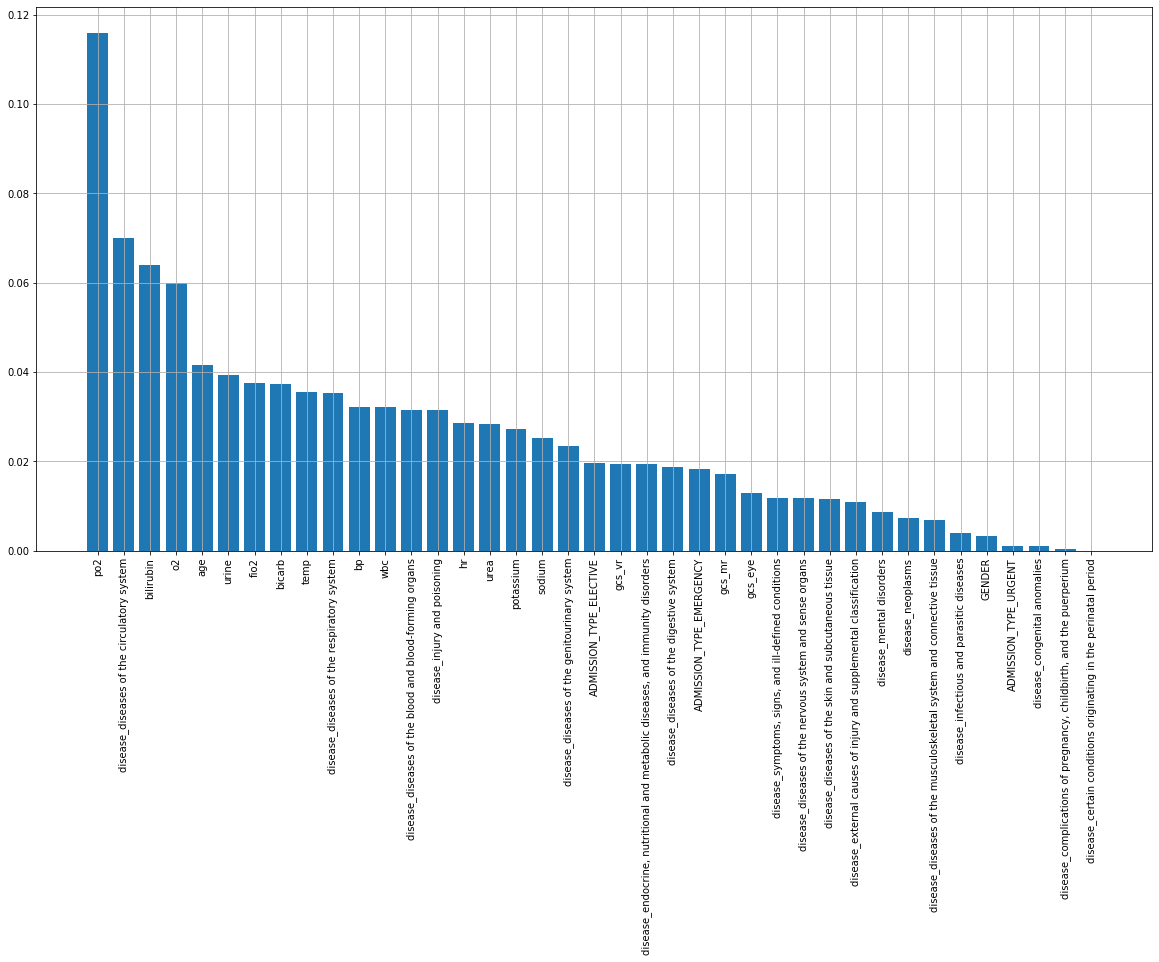

0.736857825567503
0.8465501792114696


In [126]:
# Baseline 1: Random Forest
rfc = RandomForestClassifier(max_depth=10, random_state=0)
rfc.fit(X_train1, y_train1)
importance = rfc.feature_importances_
fig, ax = plt.subplots(figsize=(20, 10))
a, b = zip(*sorted(zip(importance,feature_names), reverse=True))

ax.bar(b, a)

ax.set_xticklabels(labels = b, rotation=90)
ax.grid()
plt.show();
rf_score1 = rfc.score(X_test1, y_test1)
rf_score2 = rfc.score(X_train1, y_train1)
print(rf_score1)
print(rf_score2)

0.7290973272818961
0.7792682619329786


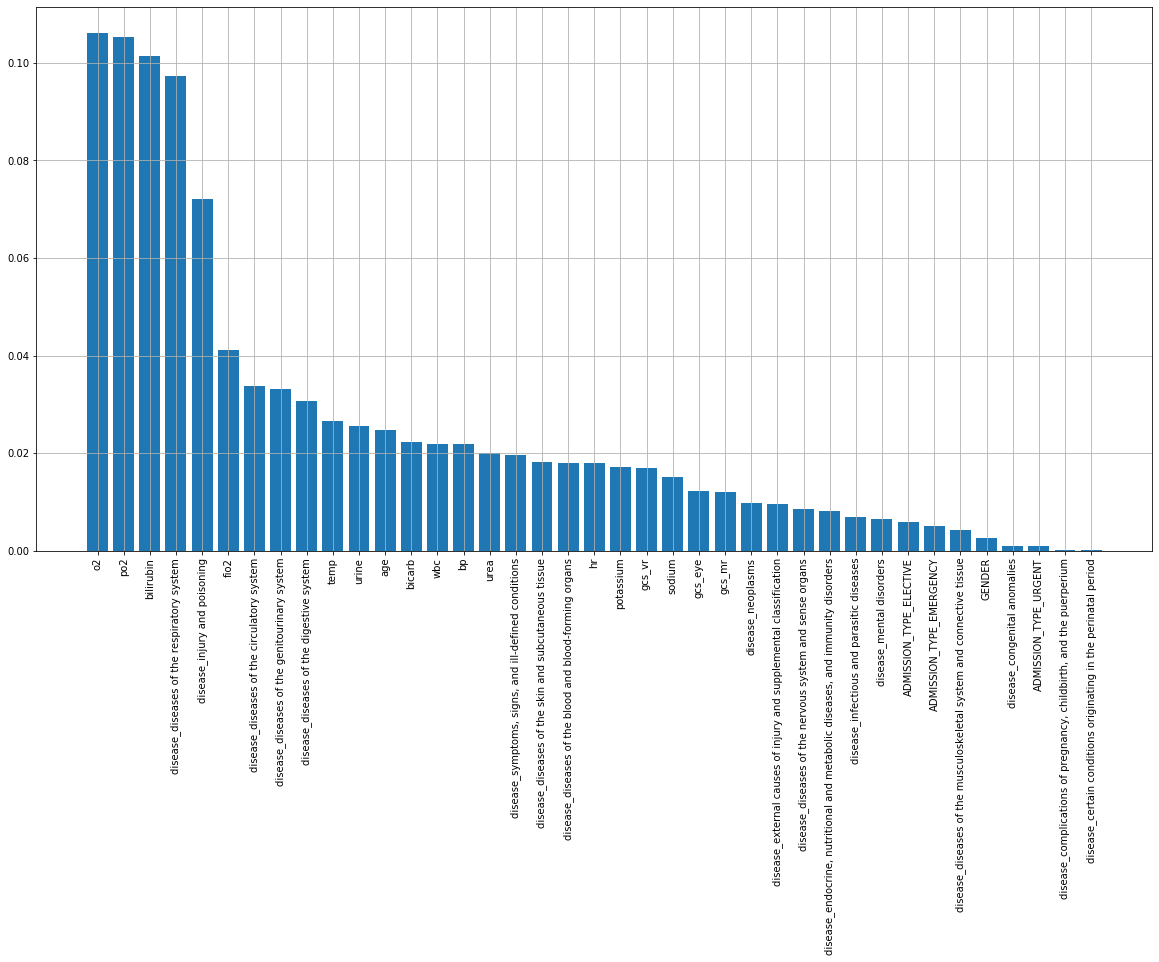

In [127]:
# Baseline 1: Random Forest
rfc = RandomForestClassifier(max_depth=10, random_state=0)
rfc.fit(X_train2, y_train2)
importance = rfc.feature_importances_
fig, ax = plt.subplots(figsize=(20, 10))
a, b = zip(*sorted(zip(importance,feature_names), reverse=True))

ax.bar(b, a)

ax.set_xticklabels(labels = b, rotation=90)
ax.grid()
rf_score1 = rfc.score(X_test2, y_test2)
rf_score2 = rfc.score(X_train2, y_train2)
print(rf_score1)
print(rf_score2)
# fig.savefig('plots/los-fi.png')

In [74]:
# Remove features with low importance

# f_names = feature_names.copy()
# def drop_unimportant(X, a, b, feature_names, set_f=0):
#     temp = X.copy()
#     unimp = []
#     for i in range(len(a)):
#         if a[i] < 0.01:
#             unimp.append(b[i])
#             if set_f:
#                 f_names.remove(b[i])
#     index = []
#     for f in unimp:
#         idx = feature_names.index(f)
#         index.append(idx)
#     temp = np.delete(temp, index, axis=1)
#     return temp

# X_train1 = drop_unimportant(X_train1, a, b, feature_names, 1)
# X_test1 = drop_unimportant(X_test1, a, b, feature_names) 
# feature_names = f_names

In [96]:
# # Baseline 2: sklearn Neural Network
# mlp = MLPClassifier().fit(X_train, y_train)
# nn_score = mlp.score(X_test, y_test)
# nn_score2 = mlp.score(X_train, y_train)
# print('Test set score: ', nn_score)
# print('Training set score', nn_score2)

Test set score:  0.652487516182726
Training set score 0.9059971332131133


In [291]:
# y_train1 = to_categorical(y_train1)
# y_test1 = to_categorical(y_test1)
# X_train1[10]

array([1.        , 1.        , 1.        , 0.5       , 0.33023256,
       0.57692308, 1.        , 0.09589041, 0.00507854, 0.12727273,
       0.02898551, 0.23998044, 0.08185725, 0.04761905, 0.37037037,
       0.64150943, 1.        , 0.42666667, 0.        , 0.        ,
       0.        , 0.125     , 0.05555556, 0.36363636, 0.        ,
       0.        , 0.        , 0.11111111, 0.11111111, 0.        ,
       0.05882353, 0.        , 0.        , 0.09090909, 0.        ,
       0.        , 0.        , 1.        , 0.        ])

Train on 11383 samples, validate on 2009 samples
Epoch 1/200
11383/11383 [==============================] - 2s 139us/step - loss: 0.6733 - accuracy: 0.5766 - val_loss: 0.6113 - val_accuracy: 0.6580
Epoch 2/200
11383/11383 [==============================] - 1s 44us/step - loss: 0.6206 - accuracy: 0.6530 - val_loss: 0.5909 - val_accuracy: 0.6824
Epoch 3/200
11383/11383 [==============================] - 1s 44us/step - loss: 0.5966 - accuracy: 0.6760 - val_loss: 0.5739 - val_accuracy: 0.7033
Epoch 4/200
11383/11383 [==============================] - 0s 44us/step - loss: 0.5860 - accuracy: 0.6881 - val_loss: 0.5769 - val_accuracy: 0.6969
Epoch 5/200
11383/11383 [==============================] - 1s 44us/step - loss: 0.5787 - accuracy: 0.6961 - val_loss: 0.5678 - val_accuracy: 0.7053
Epoch 6/200
11383/11383 [==============================] - 0s 44us/step - loss: 0.5753 - accuracy: 0.7003 - val_loss: 0.5666 - val_accuracy: 0.7098
Epoch 7/200
11383/11383 [==============================] - 0s 

Epoch 56/200
11383/11383 [==============================] - 0s 42us/step - loss: 0.4996 - accuracy: 0.7571 - val_loss: 0.5238 - val_accuracy: 0.7471
Epoch 57/200
11383/11383 [==============================] - 0s 42us/step - loss: 0.4957 - accuracy: 0.7553 - val_loss: 0.5241 - val_accuracy: 0.7461
Epoch 58/200
11383/11383 [==============================] - 0s 43us/step - loss: 0.4971 - accuracy: 0.7562 - val_loss: 0.5256 - val_accuracy: 0.7466
Epoch 59/200
11383/11383 [==============================] - 0s 42us/step - loss: 0.4952 - accuracy: 0.7563 - val_loss: 0.5260 - val_accuracy: 0.7392
Epoch 60/200
11383/11383 [==============================] - 1s 44us/step - loss: 0.4957 - accuracy: 0.7587 - val_loss: 0.5214 - val_accuracy: 0.7422
Epoch 61/200
11383/11383 [==============================] - 0s 43us/step - loss: 0.4951 - accuracy: 0.7592 - val_loss: 0.5234 - val_accuracy: 0.7461
Epoch 62/200
11383/11383 [==============================] - 0s 42us/step - loss: 0.4917 - accuracy: 0.7582

Epoch 111/200
11383/11383 [==============================] - 1s 50us/step - loss: 0.4686 - accuracy: 0.7753 - val_loss: 0.5264 - val_accuracy: 0.7407
Epoch 112/200
11383/11383 [==============================] - 1s 49us/step - loss: 0.4754 - accuracy: 0.7667 - val_loss: 0.5271 - val_accuracy: 0.7347
Epoch 113/200
11383/11383 [==============================] - 0s 43us/step - loss: 0.4697 - accuracy: 0.7732 - val_loss: 0.5287 - val_accuracy: 0.7446
Epoch 114/200
11383/11383 [==============================] - 0s 43us/step - loss: 0.4711 - accuracy: 0.7682 - val_loss: 0.5258 - val_accuracy: 0.7412
Epoch 115/200
11383/11383 [==============================] - 1s 51us/step - loss: 0.4710 - accuracy: 0.7718 - val_loss: 0.5324 - val_accuracy: 0.7342
Epoch 116/200
11383/11383 [==============================] - 1s 45us/step - loss: 0.4753 - accuracy: 0.7752 - val_loss: 0.5265 - val_accuracy: 0.7377
Epoch 117/200
11383/11383 [==============================] - 1s 44us/step - loss: 0.4668 - accuracy:

11383/11383 [==============================] - 0s 43us/step - loss: 0.4517 - accuracy: 0.7812 - val_loss: 0.5311 - val_accuracy: 0.7437
Epoch 166/200
11383/11383 [==============================] - 0s 43us/step - loss: 0.4502 - accuracy: 0.7842 - val_loss: 0.5354 - val_accuracy: 0.7372
Epoch 167/200
11383/11383 [==============================] - 0s 43us/step - loss: 0.4506 - accuracy: 0.7832 - val_loss: 0.5268 - val_accuracy: 0.7407
Epoch 168/200
11383/11383 [==============================] - 0s 44us/step - loss: 0.4539 - accuracy: 0.7827 - val_loss: 0.5320 - val_accuracy: 0.7456
Epoch 169/200
11383/11383 [==============================] - 0s 43us/step - loss: 0.4519 - accuracy: 0.7813 - val_loss: 0.5307 - val_accuracy: 0.7432
Epoch 170/200
11383/11383 [==============================] - 0s 43us/step - loss: 0.4517 - accuracy: 0.7797 - val_loss: 0.5288 - val_accuracy: 0.7402
Epoch 171/200
11383/11383 [==============================] - 0s 43us/step - loss: 0.4499 - accuracy: 0.7856 - val_

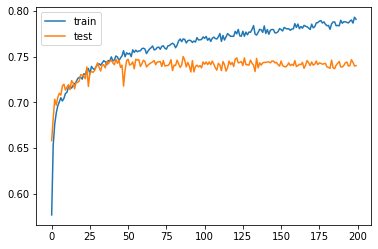

In [128]:
# Neural Network1


def nn(input_dim, output_dim=1, final_act='sigmoid', loss='binary_crossentropy'):
    model = Sequential()
    model.add(Dense(128, input_dim=input_dim, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='sigmoid'))
    model.add(Dropout(0.2))
    model.add(Dense(output_dim, activation=final_act))

    
    model.compile(loss=loss, optimizer='adam', metrics=['accuracy'])
    return model

# l_model = nn(X_train1.shape[1], output_dim=3, final_act='softmax', loss='categorical_crossentropy')
l_model = nn(X_train1.shape[1])
training = l_model.fit(X_train1, y_train1, validation_split=0.15, epochs=200, batch_size=100)
nn_score = l_model.evaluate(X_test1, y_test1)
nn_score2 = l_model.evaluate(X_train1, y_train1)
print('Test set score: ', nn_score[1])
print('Training set score', nn_score2[1])
plt.plot(training.history['accuracy'], label='train')
plt.plot(training.history['val_accuracy'], label='test')
plt.legend()
plt.show()


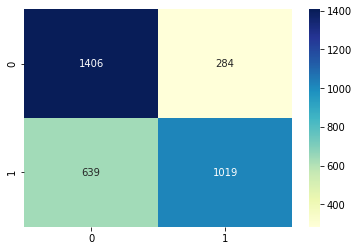

In [133]:
y_pred1 = l_model.predict(X_test1)

y_pred1 = np.round(y_pred1)

cm = confusion_matrix(y_test1, y_pred1)
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu");

Train on 33710 samples, validate on 5949 samples
Epoch 1/200
33710/33710 [==============================] - 3s 75us/step - loss: 0.6407 - accuracy: 0.6234 - val_loss: 0.5919 - val_accuracy: 0.6828
Epoch 2/200
33710/33710 [==============================] - 1s 43us/step - loss: 0.5996 - accuracy: 0.6760 - val_loss: 0.5818 - val_accuracy: 0.6934
Epoch 3/200
33710/33710 [==============================] - 1s 43us/step - loss: 0.5895 - accuracy: 0.6845 - val_loss: 0.5796 - val_accuracy: 0.7033
Epoch 4/200
33710/33710 [==============================] - 1s 43us/step - loss: 0.5859 - accuracy: 0.6898 - val_loss: 0.5789 - val_accuracy: 0.7010
Epoch 5/200
33710/33710 [==============================] - 1s 42us/step - loss: 0.5825 - accuracy: 0.6920 - val_loss: 0.5719 - val_accuracy: 0.7033
Epoch 6/200
33710/33710 [==============================] - 1s 43us/step - loss: 0.5791 - accuracy: 0.6942 - val_loss: 0.5687 - val_accuracy: 0.7065
Epoch 7/200
33710/33710 [==============================] - 1s 4

Epoch 56/200
33710/33710 [==============================] - 1s 41us/step - loss: 0.5278 - accuracy: 0.7326 - val_loss: 0.5341 - val_accuracy: 0.7285
Epoch 57/200
33710/33710 [==============================] - 1s 41us/step - loss: 0.5302 - accuracy: 0.7310 - val_loss: 0.5349 - val_accuracy: 0.7265
Epoch 58/200
33710/33710 [==============================] - 1s 41us/step - loss: 0.5293 - accuracy: 0.7339 - val_loss: 0.5334 - val_accuracy: 0.7299
Epoch 59/200
33710/33710 [==============================] - 1s 41us/step - loss: 0.5279 - accuracy: 0.7336 - val_loss: 0.5322 - val_accuracy: 0.7267
Epoch 60/200
33710/33710 [==============================] - 1s 42us/step - loss: 0.5282 - accuracy: 0.7319 - val_loss: 0.5344 - val_accuracy: 0.7257
Epoch 61/200
33710/33710 [==============================] - 1s 42us/step - loss: 0.5257 - accuracy: 0.7334 - val_loss: 0.5332 - val_accuracy: 0.7262
Epoch 62/200
33710/33710 [==============================] - 1s 42us/step - loss: 0.5257 - accuracy: 0.7341

Epoch 111/200
33710/33710 [==============================] - 2s 51us/step - loss: 0.5148 - accuracy: 0.7418 - val_loss: 0.5336 - val_accuracy: 0.7289
Epoch 112/200
33710/33710 [==============================] - 1s 43us/step - loss: 0.5150 - accuracy: 0.7425 - val_loss: 0.5310 - val_accuracy: 0.7309
Epoch 113/200
33710/33710 [==============================] - 2s 48us/step - loss: 0.5140 - accuracy: 0.7415 - val_loss: 0.5319 - val_accuracy: 0.7294
Epoch 114/200
33710/33710 [==============================] - 1s 44us/step - loss: 0.5138 - accuracy: 0.7420 - val_loss: 0.5334 - val_accuracy: 0.7284
Epoch 115/200
33710/33710 [==============================] - 1s 42us/step - loss: 0.5124 - accuracy: 0.7436 - val_loss: 0.5318 - val_accuracy: 0.7307
Epoch 116/200
33710/33710 [==============================] - 1s 42us/step - loss: 0.5122 - accuracy: 0.7455 - val_loss: 0.5332 - val_accuracy: 0.7270
Epoch 117/200
33710/33710 [==============================] - 2s 47us/step - loss: 0.5125 - accuracy:

33710/33710 [==============================] - 1s 42us/step - loss: 0.5076 - accuracy: 0.7465 - val_loss: 0.5369 - val_accuracy: 0.7220
Epoch 166/200
33710/33710 [==============================] - 1s 41us/step - loss: 0.5055 - accuracy: 0.7447 - val_loss: 0.5372 - val_accuracy: 0.7255
Epoch 167/200
33710/33710 [==============================] - 1s 41us/step - loss: 0.5061 - accuracy: 0.7469 - val_loss: 0.5369 - val_accuracy: 0.7280
Epoch 168/200
33710/33710 [==============================] - 1s 41us/step - loss: 0.5047 - accuracy: 0.7478 - val_loss: 0.5399 - val_accuracy: 0.7295
Epoch 169/200
33710/33710 [==============================] - 1s 41us/step - loss: 0.5053 - accuracy: 0.7477 - val_loss: 0.5370 - val_accuracy: 0.7268
Epoch 170/200
33710/33710 [==============================] - 1s 41us/step - loss: 0.5043 - accuracy: 0.7473 - val_loss: 0.5366 - val_accuracy: 0.7305
Epoch 171/200
33710/33710 [==============================] - 1s 40us/step - loss: 0.5067 - accuracy: 0.7445 - val_

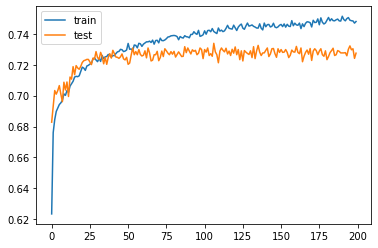

In [129]:
l_model = nn(X_train2.shape[1])
training = l_model.fit(X_train2, y_train2, validation_split=0.15, epochs=200, batch_size=100)
nn_score = l_model.evaluate(X_test2, y_test2)
nn_score2 = l_model.evaluate(X_train2, y_train2)
print('Test set score: ', nn_score[1])
print('Training set score', nn_score2[1])
plt.plot(training.history['accuracy'], label='train')
plt.plot(training.history['val_accuracy'], label='test')
plt.legend()
plt.show()

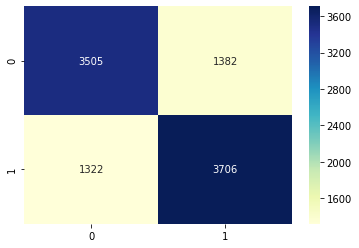

In [132]:
y_pred2 = l_model.predict(X_test2)

y_pred2 = np.round(y_pred2)



cm = confusion_matrix(y_test2, y_pred2)
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu");


In [59]:
# # Single Sample Explainer

# explainer = shap.DeepExplainer(l_model, X_train)
# shap_values = explainer.shap_values(X_test[:2, :])
# explainer.expected_value
# shap.force_plot(explainer.expected_value, shap_values[0,:], X_test[0])
# predict_fn = lambda x: l_model.predict(x)

array([0.7579103 , 0.19984806, 0.03925155, 0.00299176], dtype=float32)

In [ ]:
# 存档
#     model.add(Dense(39*8, input_dim=X_train.shape[1], kernel_initializer='normal', activation='sigmoid'))
#     model.add(Dropout(0.1))
#     model.add(Dense(39*8, activation='relu'))
#     model.add(Dropout(0.2))

#     model.add(Dense(1, activation=None))
#     model.add(BatchNormalization())
#     model.add(Activation(activation='relu'))

In [33]:
# explaniner = lime.lime_tabular.LimeTabularExplainer(X_train, class_names=['<1', '1-3', '3-7', '>7'], feature_names=feature_names, discretize_continuous=True)

In [47]:
# permutation_importance(l_model, feature_names, X_test, y_test)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:2295: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:2295: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:2295: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:2295: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:2295: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/pyt

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:2295: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:2295: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:2295: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:2295: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:2295: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/pyt

IndexError: index 0 is out of bounds for axis 0 with size 0

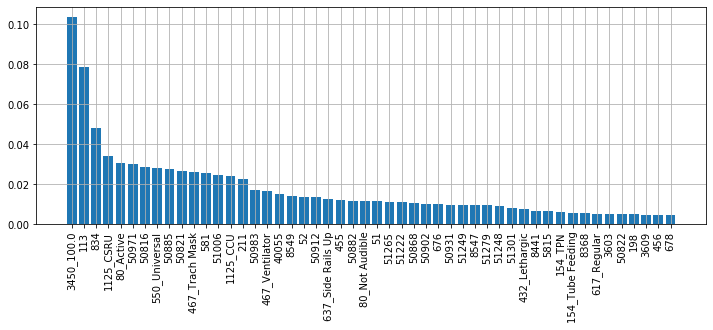

In [176]:

# nn_y = l_model.predict(X_test)
# idx = np.argmax(nn_y, axis=-1)
# nn_y = np.zeros(nn_y.shape)
# nn_y[np.arange(nn_y.shape[0]), idx] = 1

# surrogate_nn = DecisionTreeClassifier().fit(X_test, nn_y)
# fig, ax = plt.subplots(figsize=(12, 4))

# a, b = zip(*sorted(zip(surrogate_nn.feature_importances_,f_names), reverse=True))

# ax.bar(x=b[:50], height=a[:50])
# ax.set_xticklabels(labels = b[:50], rotation=90)
# ax.grid()

In [23]:
d_items = pd.read_csv('mimic/D_ITEMS.csv')
d_labitems = pd.read_csv('mimic/D_LABITEMS.csv')

In [26]:
d_labitems[(d_labitems['ITEMID']==50983)|(d_labitems['ITEMID']==50912)|(d_labitems['ITEMID']==50882)|
          (d_labitems['ITEMID']==51265)|(d_labitems['ITEMID']==51222)|(d_labitems['ITEMID']==50816)|
          (d_labitems['ITEMID']==50971)|(d_labitems['ITEMID']==50868)|(d_labitems['ITEMID']==50885)|
           (d_labitems['ITEMID']==51006)|(d_labitems['ITEMID']==51301)|(d_labitems['ITEMID']==50885)|
          (d_labitems['ITEMID']==50821)]

,ROW_ID,ITEMID,LABEL,FLUID,CATEGORY,LOINC_CODE
143,17,50816,Oxygen,Blood,Blood Gas,19994-3
148,22,50821,pO2,Blood,Blood Gas,11556-8
195,69,50868,Anion Gap,Blood,Chemistry,1863-0
209,83,50882,Bicarbonate,Blood,Chemistry,1963-8
212,86,50885,"Bilirubin, Total",Blood,Chemistry,1975-2
239,113,50912,Creatinine,Blood,Chemistry,2160-0
298,172,50971,Potassium,Blood,Chemistry,2823-3
310,184,50983,Sodium,Blood,Chemistry,2951-2
332,206,51006,Urea Nitrogen,Blood,Chemistry,3094-0
548,422,51222,Hemoglobin,Blood,Hematology,718-7


In [36]:
d_items[(d_items['ITEMID']==3420)|(d_items['ITEMID']==113)|(d_items['ITEMID']==834)|
       (d_items['ITEMID']==1125)|(d_items['ITEMID']==80)|(d_items['ITEMID']==550)|
       (d_items['ITEMID']==467)|(d_items['ITEMID']==40055)|(d_items['ITEMID']==8549)|
       (d_items['ITEMID']==52)|(d_items['ITEMID']==637)|(d_items['ITEMID']==455)|
        (d_items['ITEMID']==3450)|(d_items['ITEMID']==678)|(d_items['ITEMID']==128)|
       (d_items['ITEMID']==432)|(d_items['ITEMID']==51)|(d_items['ITEMID']==676)]

,ROW_ID,ITEMID,LABEL,ABBREVIATION,DBSOURCE,LINKSTO,CATEGORY,UNITNAME,PARAM_TYPE,CONCEPTID
118,1270,1125,Service Type,NaN,carevue,chartevents,NaN,NaN,NaN,NaN
195,507,550,Precautions,NaN,carevue,chartevents,NaN,NaN,NaN,NaN
320,57,51,Arterial BP [Systolic],NaN,carevue,chartevents,NaN,NaN,NaN,NaN
321,58,52,Arterial BP Mean,NaN,carevue,chartevents,NaN,NaN,NaN,NaN
348,85,80,Bowel Sounds,NaN,carevue,chartevents,NaN,NaN,NaN,NaN
381,118,113,CVP,NaN,carevue,chartevents,NaN,NaN,NaN,NaN
394,131,128,Code Status,NaN,carevue,chartevents,NaN,NaN,NaN,NaN
662,399,432,Level of Conscious,NaN,carevue,chartevents,NaN,NaN,NaN,NaN
682,419,455,NBP [Systolic],NaN,carevue,chartevents,NaN,NaN,NaN,NaN
694,431,467,O2 Delivery Device,NaN,carevue,chartevents,NaN,NaN,NaN,NaN


# Mortality

In [86]:

table = pd.read_csv('16features.csv')

admission = pd.read_csv("mimic/ADMISSIONS.csv")
patient = pd.read_csv('mimic/PATIENTS.csv')
diagnoses = pd.read_csv('mimic/DIAGNOSES_ICD.csv')
admission['LOS'] = (pd.to_datetime(admission['DISCHTIME']) - pd.to_datetime(admission['ADMITTIME'])).dt.total_seconds()/86400
admission = admission[admission['LOS']>0]
admission = admission.merge(patient, on='SUBJECT_ID')
admission['age'] = calculate_age(admission, 'ADMITTIME', 'DOB')
admission = admission[admission['age']>=15]
admission['GENDER'] = admission['GENDER'].apply(lambda x: 1 if x=='M' else 0)
diagnoses['disease'] = diagnoses['ICD9_CODE'].apply(lambda x: D_Category[assign_category(x)])
diagnoses = diagnoses[['HADM_ID', 'disease']]
diag_oh = pd.get_dummies(diagnoses, columns=['disease'])
diag_oh = diag_oh.groupby('HADM_ID').sum()


admission = admission[['HADM_ID', 'ADMISSION_TYPE', 'GENDER', 'age', 'HOSPITAL_EXPIRE_FLAG']]
admission = admission.merge(diag_oh, on='HADM_ID')
admission

,HADM_ID,ADMISSION_TYPE,GENDER,age,HOSPITAL_EXPIRE_FLAG,disease_certain conditions originating in the perinatal period,"disease_complications of pregnancy, childbirth, and the puerperium",disease_congenital anomalies,disease_diseases of the blood and blood-forming organs,disease_diseases of the circulatory system,...,disease_diseases of the nervous system and sense organs,disease_diseases of the respiratory system,disease_diseases of the skin and subcutaneous tissue,"disease_endocrine, nutritional and metabolic diseases, and immunity disorders",disease_external causes of injury and supplemental classification,disease_infectious and parasitic diseases,disease_injury and poisoning,disease_mental disorders,disease_neoplasms,"disease_symptoms, signs, and ill-defined conditions"
0,165315,EMERGENCY,0,65,0,0,0,0,0,1,...,1,0,0,0,2,0,2,1,0,0
1,152223,ELECTIVE,1,71,0,0,0,0,0,4,...,1,0,0,1,1,0,0,0,0,0
2,124321,EMERGENCY,1,75,0,0,0,0,0,2,...,1,0,0,2,3,0,0,0,1,1
3,161859,EMERGENCY,1,39,0,0,0,0,0,2,...,0,0,0,1,0,0,0,0,0,0
4,129635,EMERGENCY,1,59,0,0,0,0,0,3,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50772,190603,ELECTIVE,1,78,0,0,0,0,0,1,...,1,0,0,0,3,0,0,0,0,0
50773,105447,EMERGENCY,1,88,1,0,0,0,0,1,...,3,1,0,1,1,0,1,0,0,0
50774,191113,EMERGENCY,0,20,0,0,0,0,1,0,...,0,0,0,0,1,0,5,0,0,0
50775,101071,EMERGENCY,0,84,1,0,0,0,0,3,...,0,0,0,0,1,0,0,0,0,0


In [88]:
data = table.merge(admission, on='HADM_ID')
data = pd.get_dummies(data, columns=['ADMISSION_TYPE'])

label_0 = data[data['HOSPITAL_EXPIRE_FLAG']==0]
label_1 = data[data['HOSPITAL_EXPIRE_FLAG']==1]

base_num = min(len(label_0), len(label_1))
label_0 = label_0.sample(n=base_num, random_state=2)
data = pd.concat([label_0, label_1])

y = data['HOSPITAL_EXPIRE_FLAG'].to_numpy()
X = data.drop(['HOSPITAL_EXPIRE_FLAG', 'Unnamed: 0', 'HADM_ID'], axis=1)

feature_names=list(X)

y

array([0, 0, 0, ..., 1, 1, 1])

In [89]:
Counter(y)

Counter({0: 5715, 1: 5715})

In [90]:

X = mm.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

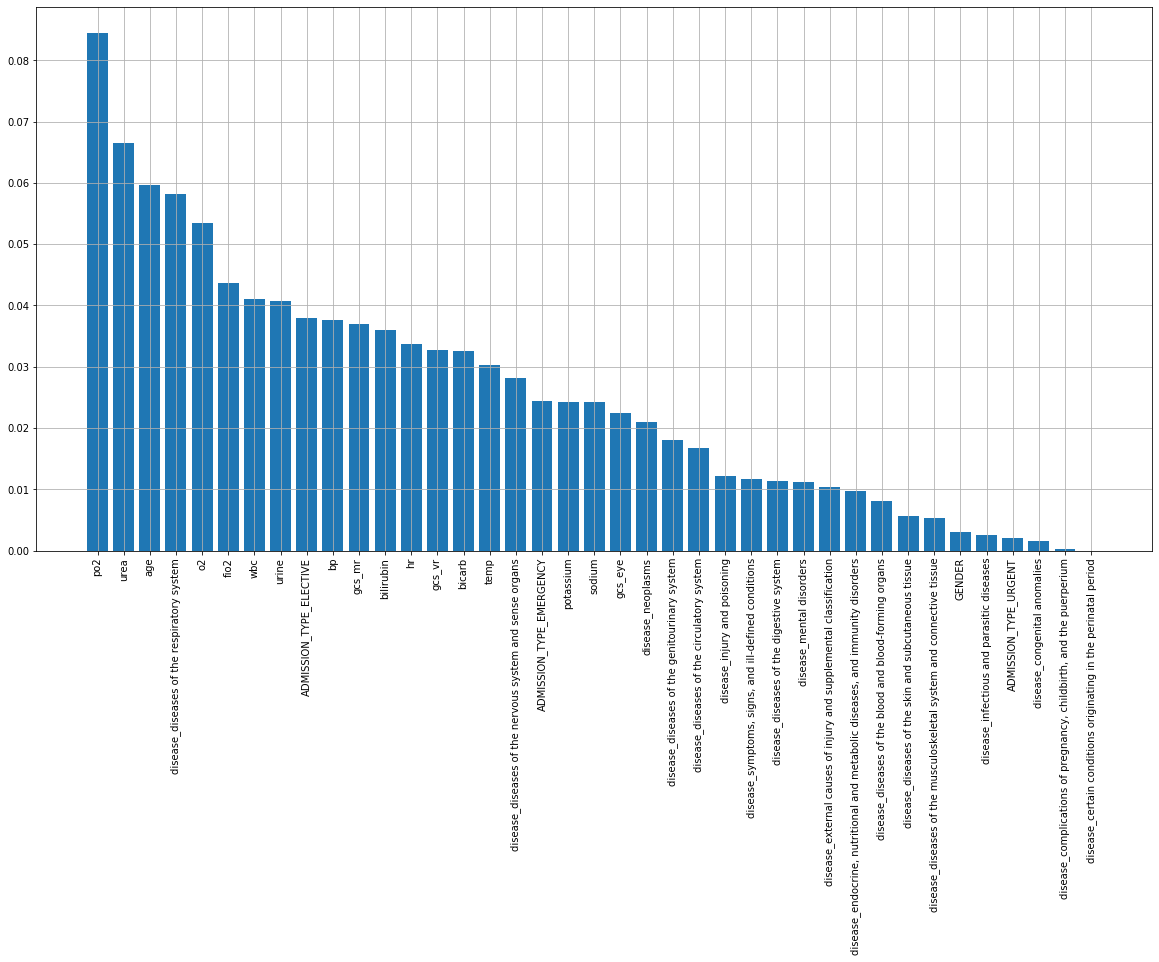

In [73]:
# RandomForest
rfc = RandomForestClassifier(max_depth=10, random_state=0)
rfc.fit(X_train, y_train)
importance = rfc.feature_importances_

fig, ax = plt.subplots(figsize=(20, 10))
a, b = zip(*sorted(zip(importance,feature_names), reverse=True))

ax.bar(b[:50], a[:50])
ax.set_xticklabels(labels = b[:50], rotation=90)
ax.grid()
# fig.savefig('plots/m_fi.png')

In [74]:
print(rfc.score(X_test, y_test))
print(rfc.score(X_train, y_train))
y_true = y_test
y_scores = rfc.predict_proba(X_test)[:, 1]

auroc = roc_auc_score(y_true, y_scores)
print(auroc)

0.7839020122484689
0.9015748031496063
0.8679139160386358


In [246]:
# LogisticRegression
lr = LogisticRegression()
lr.fit(X_train, y_train)

lr_score1 = lr.score(X_test, y_test)
lr_score2 = lr.score(X_train, y_train)
print(lr_score1)
print(lr_score2)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.883471837488458
0.897317512350524


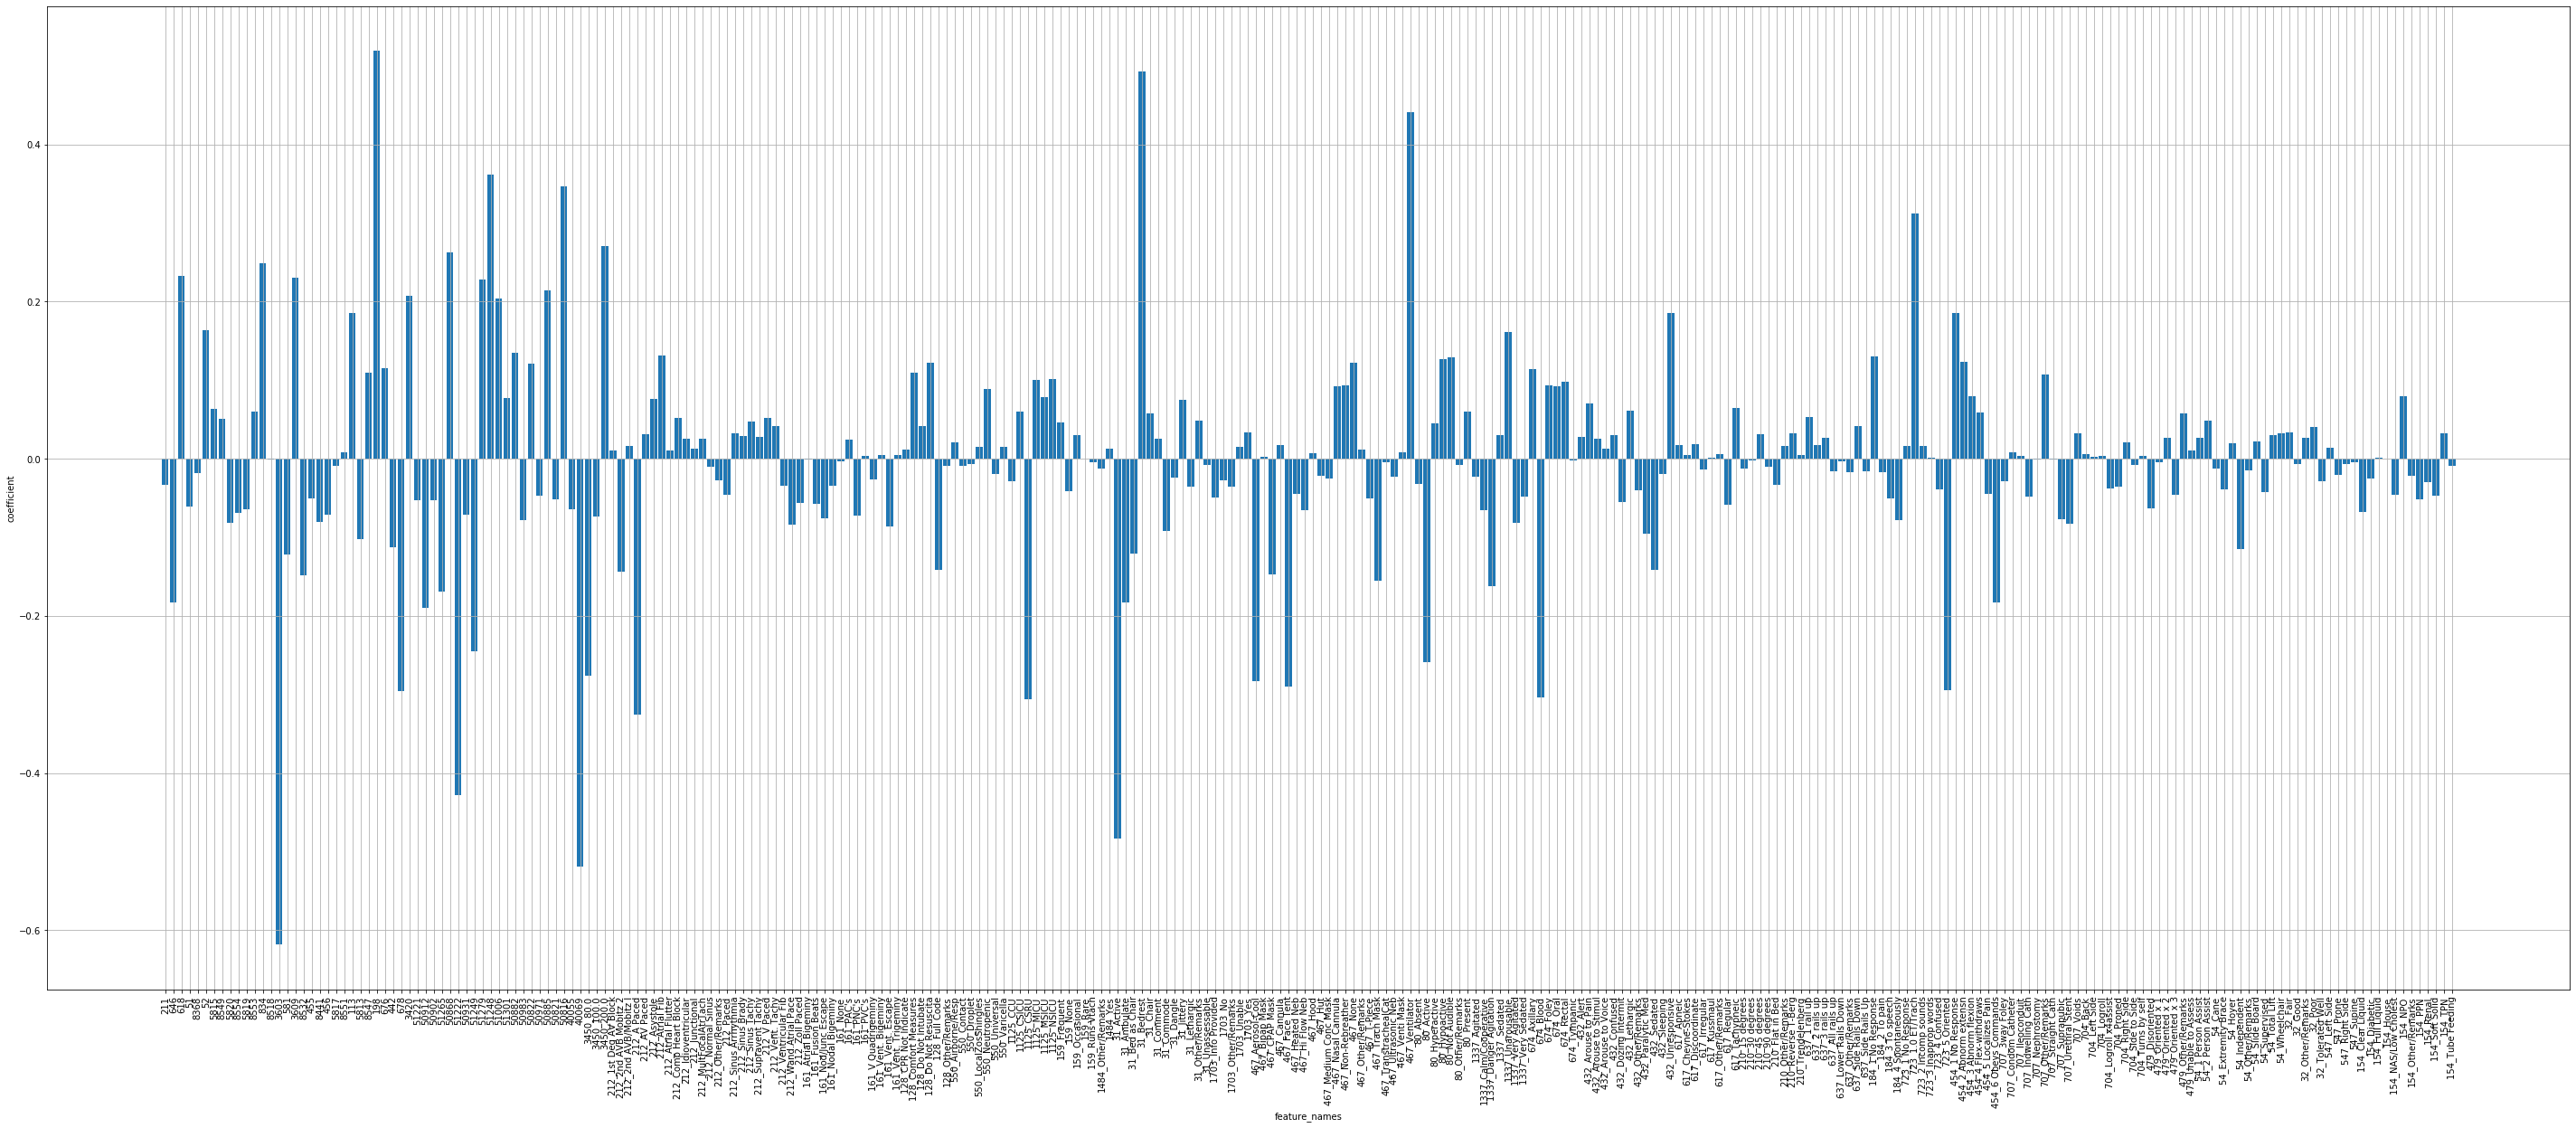

In [97]:
explain_logistic_regression(lr, feature_names)

Train on 7772 samples, validate on 1372 samples
Epoch 1/200
7772/7772 [==============================] - 1s 157us/step - loss: 0.6657 - accuracy: 0.5848 - val_loss: 0.5696 - val_accuracy: 0.7376
Epoch 2/200
7772/7772 [==============================] - 0s 56us/step - loss: 0.5720 - accuracy: 0.7014 - val_loss: 0.5326 - val_accuracy: 0.7340
Epoch 3/200
7772/7772 [==============================] - 0s 52us/step - loss: 0.5403 - accuracy: 0.7285 - val_loss: 0.5159 - val_accuracy: 0.7405
Epoch 4/200
7772/7772 [==============================] - 0s 54us/step - loss: 0.5302 - accuracy: 0.7343 - val_loss: 0.5042 - val_accuracy: 0.7456
Epoch 5/200
7772/7772 [==============================] - 0s 53us/step - loss: 0.5244 - accuracy: 0.7396 - val_loss: 0.5017 - val_accuracy: 0.7507
Epoch 6/200
7772/7772 [==============================] - 0s 56us/step - loss: 0.5151 - accuracy: 0.7463 - val_loss: 0.4951 - val_accuracy: 0.7529
Epoch 7/200
7772/7772 [==============================] - 0s 55us/step - los

7772/7772 [==============================] - 0s 39us/step - loss: 0.4198 - accuracy: 0.8106 - val_loss: 0.4493 - val_accuracy: 0.7952
Epoch 57/200
7772/7772 [==============================] - 0s 39us/step - loss: 0.4200 - accuracy: 0.8103 - val_loss: 0.4436 - val_accuracy: 0.7952
Epoch 58/200
7772/7772 [==============================] - 0s 39us/step - loss: 0.4178 - accuracy: 0.8080 - val_loss: 0.4465 - val_accuracy: 0.8039
Epoch 59/200
7772/7772 [==============================] - 0s 39us/step - loss: 0.4184 - accuracy: 0.8087 - val_loss: 0.4445 - val_accuracy: 0.7996
Epoch 60/200
7772/7772 [==============================] - 0s 39us/step - loss: 0.4157 - accuracy: 0.8102 - val_loss: 0.4430 - val_accuracy: 0.8032
Epoch 61/200
7772/7772 [==============================] - 0s 39us/step - loss: 0.4099 - accuracy: 0.8181 - val_loss: 0.4408 - val_accuracy: 0.8069
Epoch 62/200
7772/7772 [==============================] - 0s 39us/step - loss: 0.4179 - accuracy: 0.8136 - val_loss: 0.4454 - val_a

Epoch 112/200
7772/7772 [==============================] - 0s 48us/step - loss: 0.3849 - accuracy: 0.8276 - val_loss: 0.4470 - val_accuracy: 0.7988
Epoch 113/200
7772/7772 [==============================] - 0s 41us/step - loss: 0.3816 - accuracy: 0.8278 - val_loss: 0.4474 - val_accuracy: 0.8025
Epoch 114/200
7772/7772 [==============================] - 0s 43us/step - loss: 0.3820 - accuracy: 0.8294 - val_loss: 0.4465 - val_accuracy: 0.8061
Epoch 115/200
7772/7772 [==============================] - 0s 41us/step - loss: 0.3767 - accuracy: 0.8329 - val_loss: 0.4478 - val_accuracy: 0.8069
Epoch 116/200
7772/7772 [==============================] - 0s 47us/step - loss: 0.3795 - accuracy: 0.8286 - val_loss: 0.4459 - val_accuracy: 0.8032
Epoch 117/200
7772/7772 [==============================] - 0s 43us/step - loss: 0.3759 - accuracy: 0.8296 - val_loss: 0.4498 - val_accuracy: 0.7966
Epoch 118/200
7772/7772 [==============================] - 0s 51us/step - loss: 0.3776 - accuracy: 0.8289 - val_

7772/7772 [==============================] - 0s 42us/step - loss: 0.3523 - accuracy: 0.8412 - val_loss: 0.4527 - val_accuracy: 0.8061
Epoch 168/200
7772/7772 [==============================] - 0s 38us/step - loss: 0.3583 - accuracy: 0.8398 - val_loss: 0.4569 - val_accuracy: 0.7996
Epoch 169/200
7772/7772 [==============================] - 0s 41us/step - loss: 0.3534 - accuracy: 0.8456 - val_loss: 0.4588 - val_accuracy: 0.7988
Epoch 170/200
7772/7772 [==============================] - 0s 43us/step - loss: 0.3549 - accuracy: 0.8446 - val_loss: 0.4567 - val_accuracy: 0.7981
Epoch 171/200
7772/7772 [==============================] - 0s 44us/step - loss: 0.3544 - accuracy: 0.8423 - val_loss: 0.4493 - val_accuracy: 0.8061
Epoch 172/200
7772/7772 [==============================] - 0s 37us/step - loss: 0.3539 - accuracy: 0.8495 - val_loss: 0.4496 - val_accuracy: 0.7988
Epoch 173/200
7772/7772 [==============================] - 0s 52us/step - loss: 0.3569 - accuracy: 0.8396 - val_loss: 0.4520 -

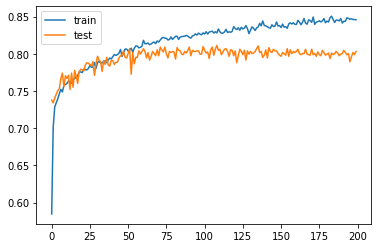

In [99]:
# Neural Network
m_model = Sequential()
m_model.add(Dense(128, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))
m_model.add(Dropout(0.2))
m_model.add(Dense(128, activation='sigmoid'))
m_model.add(Dropout(0.2))
m_model.add(Dense(1, activation='sigmoid'))

m_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
nn = m_model.fit(X_train, y_train, validation_split=0.15, epochs=200, batch_size=100)
nn_score = m_model.evaluate(X_test, y_test)
nn_score2 = m_model.evaluate(X_train, y_train)
print(nn_score[1])
print(nn_score2[1])
plt.plot(nn.history['accuracy'], label='train')
plt.plot(nn.history['val_accuracy'], label='test')
plt.legend()
plt.show()


AUROC:  0.864343814774656


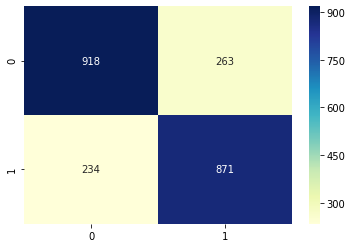

In [102]:

y_true = y_test
y_scores = m_model.predict_proba(X_test)
y_pred = m_model.predict(X_test)


y_pred = np.round(y_pred)
y_pred = y_pred.flatten()
# print(Counter(y_test))
# print(Counter(y_pred))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu");
auroc = roc_auc_score(y_true, y_scores)
print("AUROC: ", auroc)

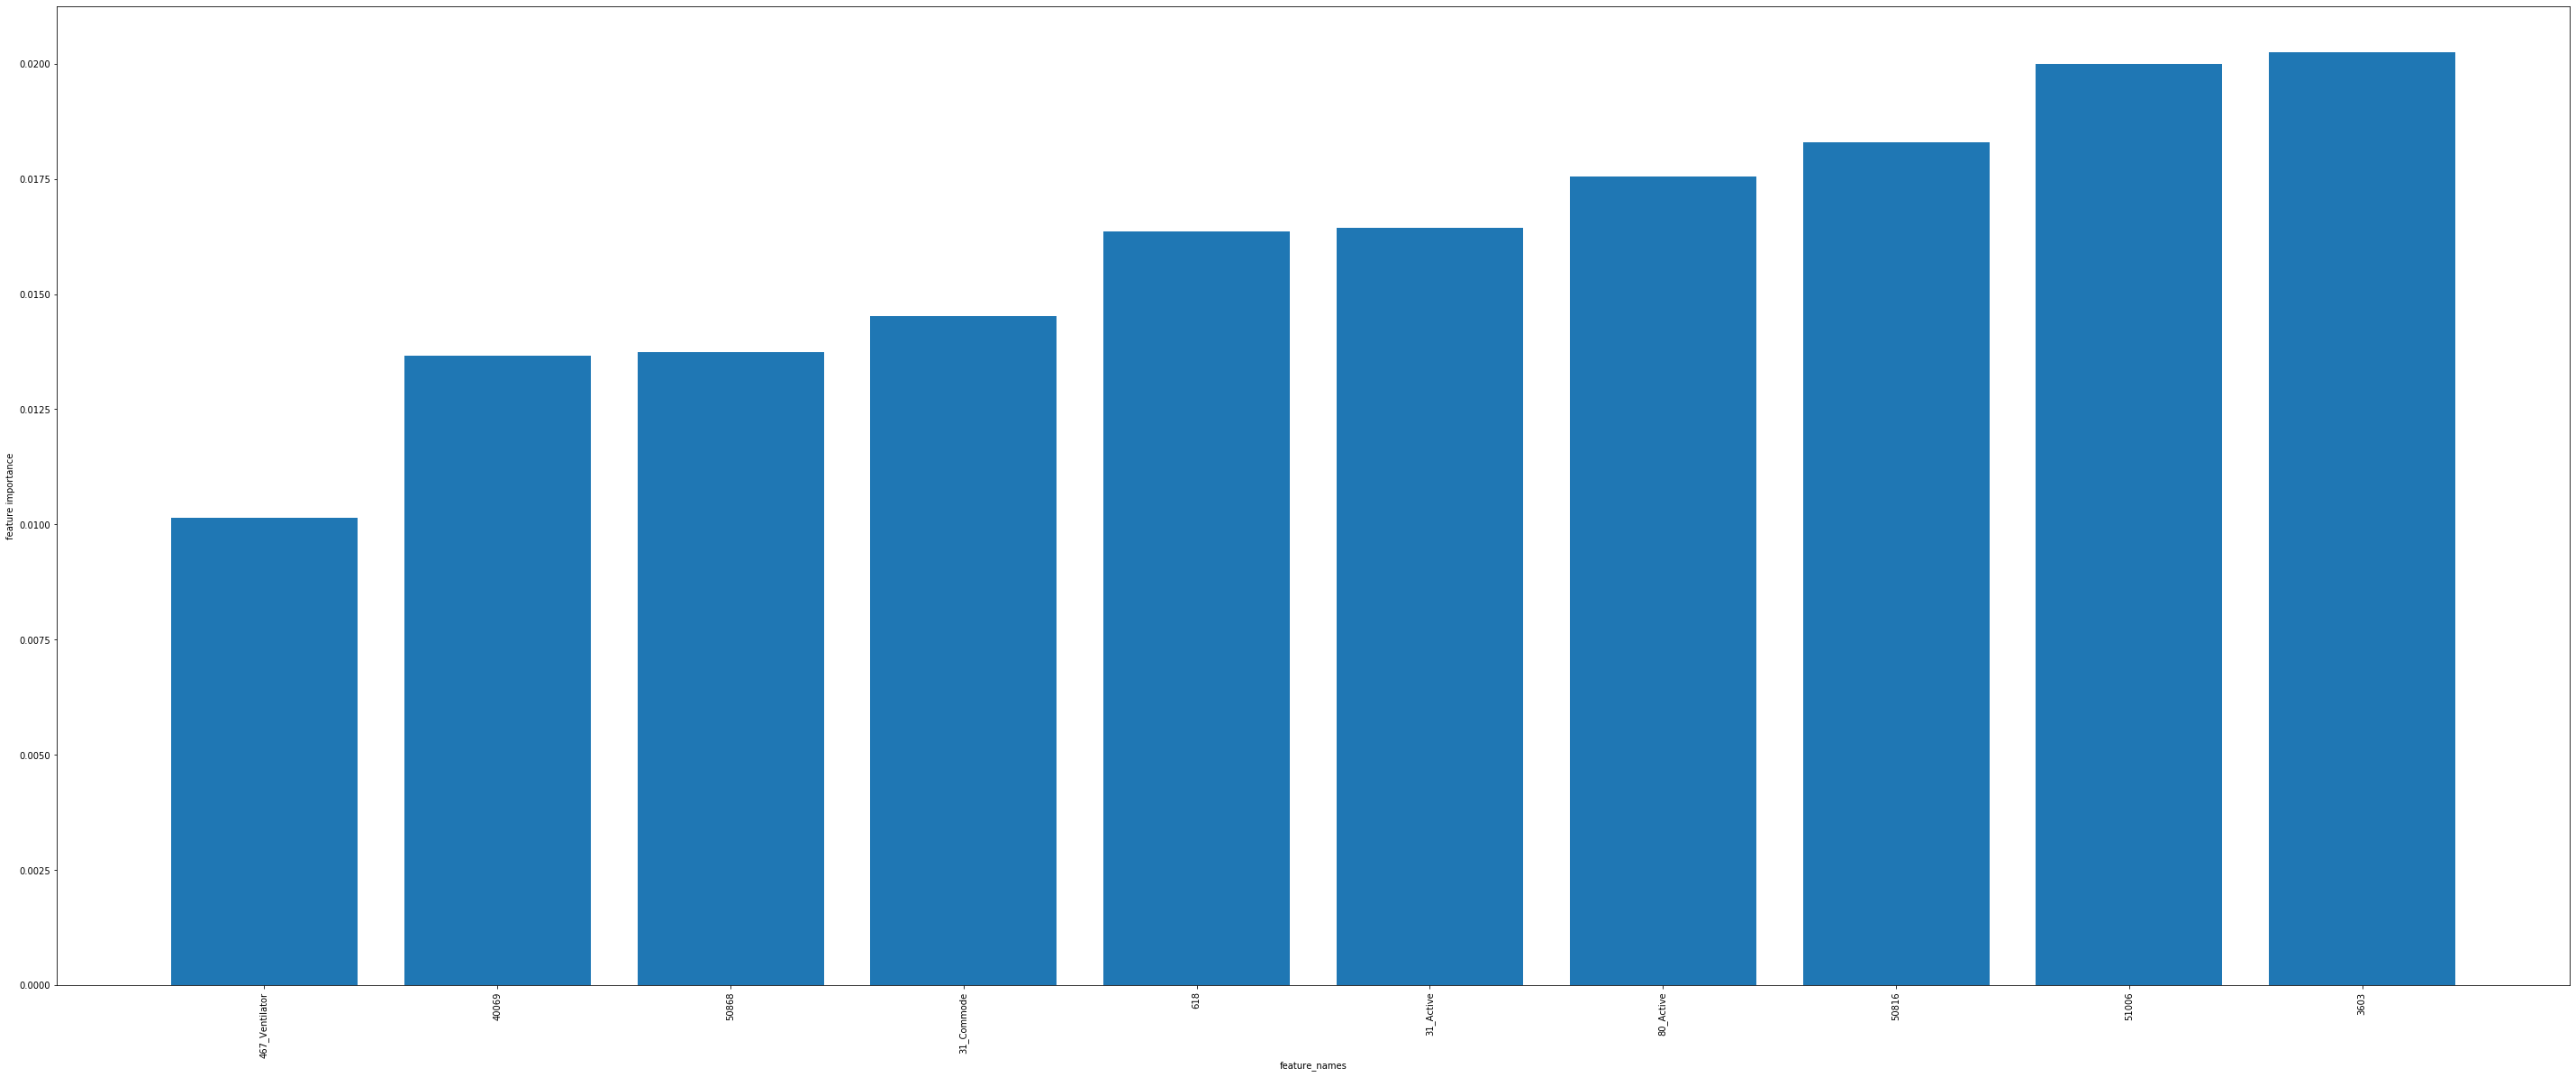

In [65]:
# permutation_importance(m_model, feature_names, X_test, y_test)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


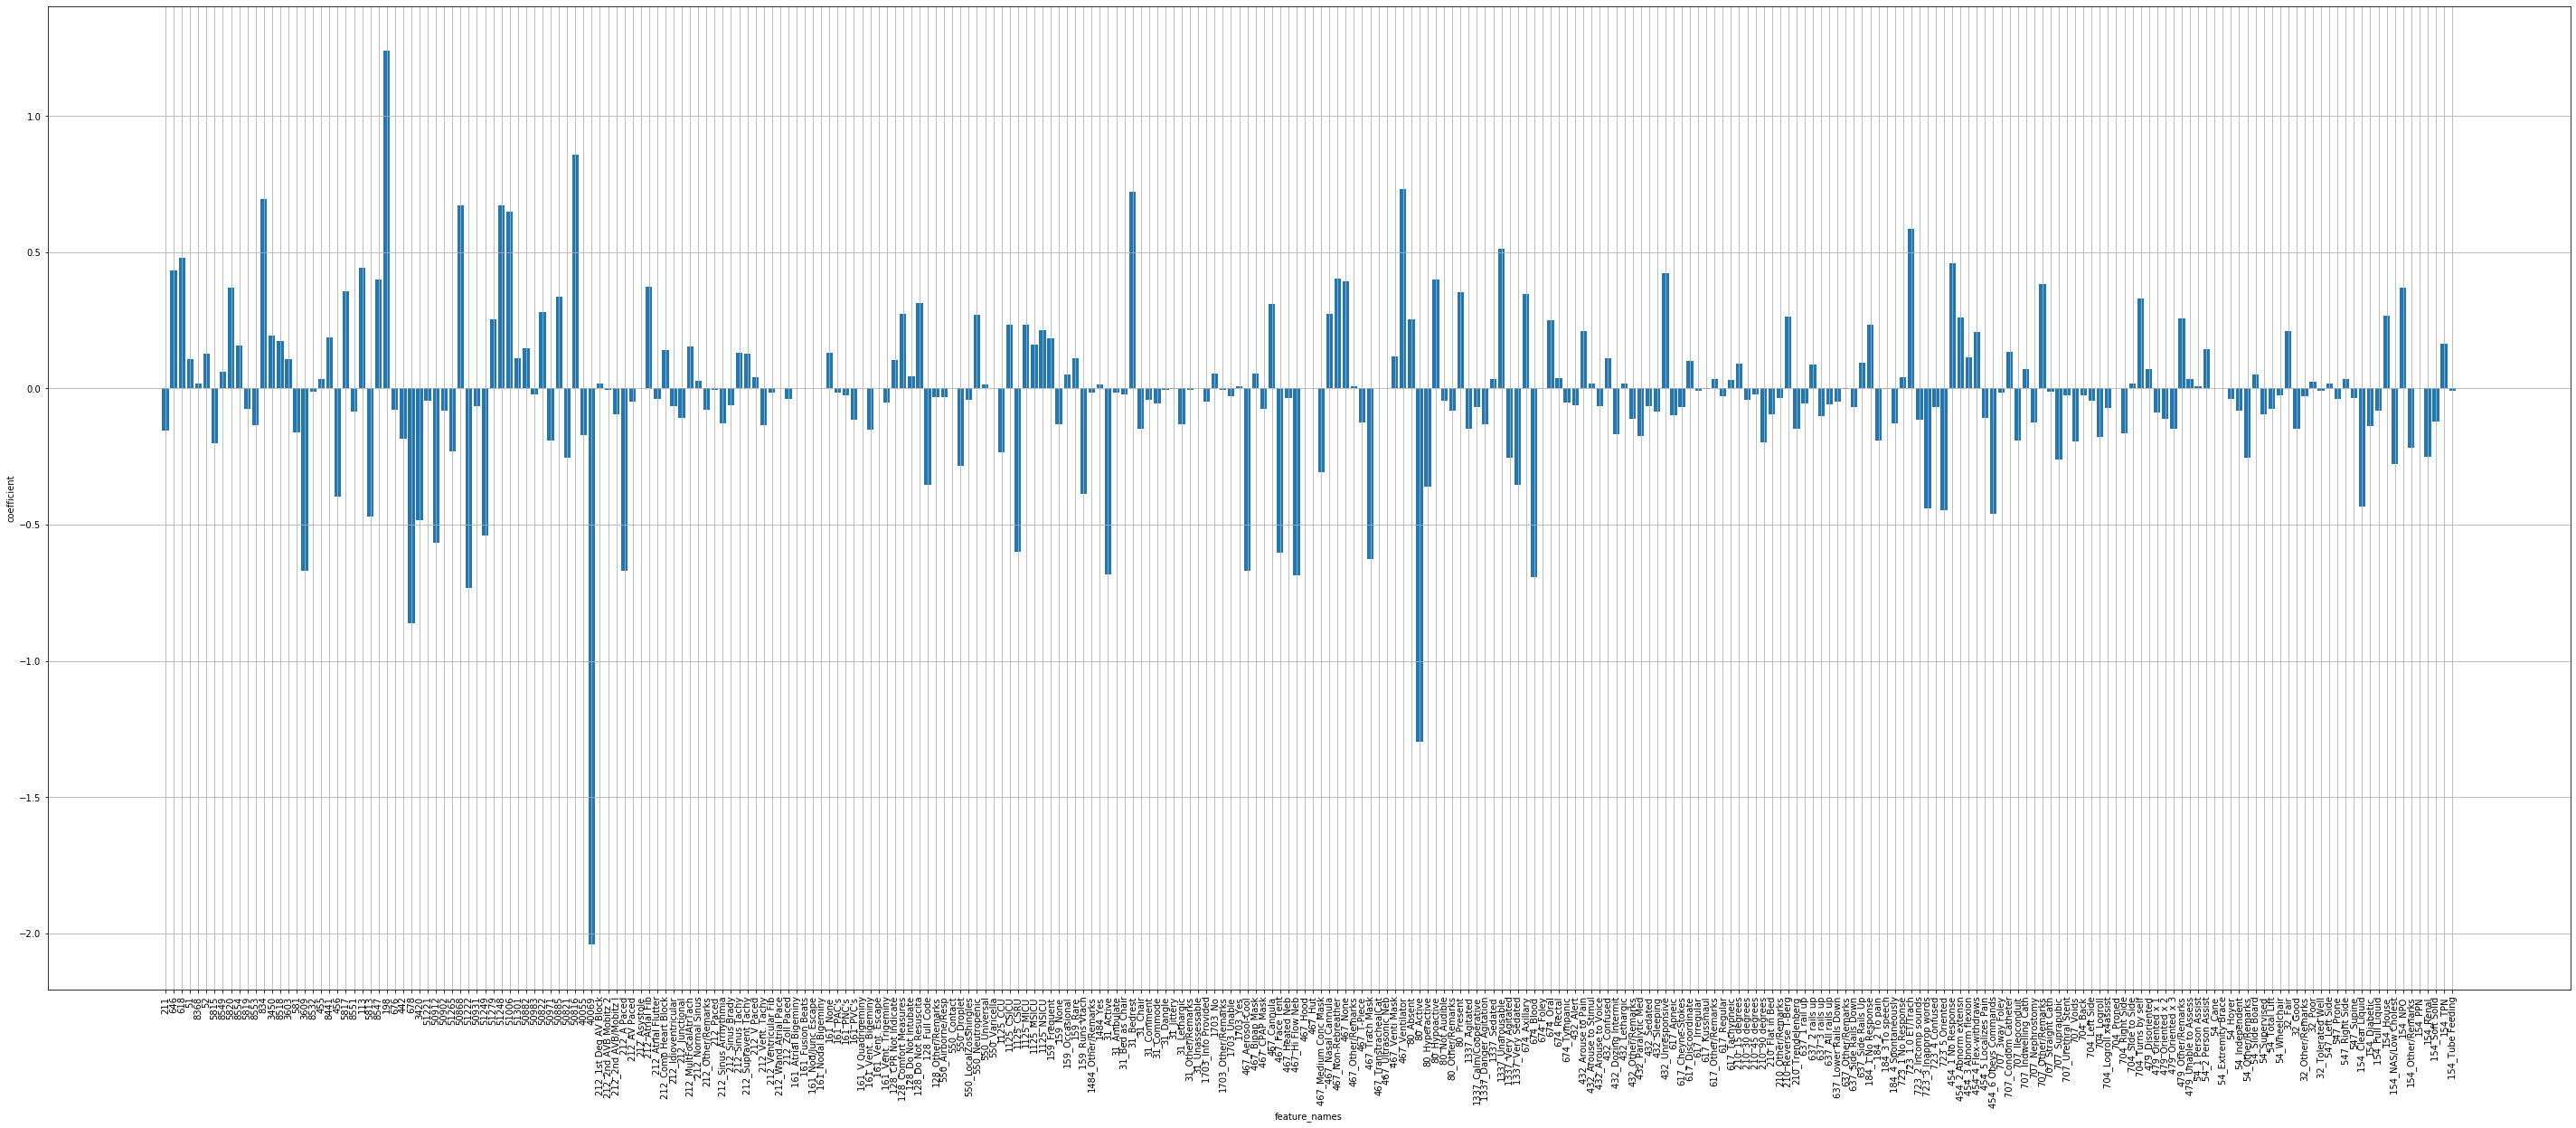

In [66]:
# nn_y = m_model.predict(X_test)
# nn_y[nn_y>0.5]=1
# nn_y[nn_y<=0.5]=0

# surrogate_nn = LogisticRegression(solver='newton-cg').fit(X_test, nn_y)
# explain_logistic_regression(surrogate_nn, feature_names)